In [118]:
from sklearn import model_selection, metrics, preprocessing, datasets, ensemble, svm, tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, f1_score, accuracy_score, precision_score, roc_auc_score
from sklearn.linear_model import LogisticRegression 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE
from random import sample
from matplotlib import pyplot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import statistics
import plotly.express as px
import umap.umap_ as umap
import xgboost

df = pd.read_csv('data.csv')

In [119]:
def plot_cm (cm):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(cm, cmap=plt.cm.Blues, alpha=0.3)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color = 'black')
    plt.show()
    
    
def mere_kvaliteta (test_y, pred_y):
    f1 = f1_score(test_y, pred_y, average='macro')
    auc = roc_auc_score(test_y, pred_y)
    precision = precision_score(test_y, pred_y)
    print('F1 Score : %.2f' % f1)
    print('AUC ROC : %.2f' % auc)
    print('Precision : %.2f' % precision)
    
def grafik_3d (colors, train_X):
    fig = px.scatter_3d(
        train_X, x=0, y=1, z=2,
        color=(colors), 
        labels={'color': 'Bankrupcy?'}
    )
    fig.update_traces(marker_size=2)
    fig.show()
    
def grafik_2d (train_X,train_y):
    plt.scatter(train_X[:,0][train_y==0], train_X[:,1][train_y==0], s=5, c='b')
    plt.scatter(train_X[:,0][train_y==1], train_X[:,1][train_y==1], s=5, c='r')
    plt.show()
    
def plot_ksd(explained_variance_ratio_):    
    plt.figure(figsize = (6,3))
    plt.plot(np.cumsum(explained_variance_ratio_))
    plt.xlabel('Broj glavnih komponenti')
    plt.ylabel('Kumulativna suma disperzije')
    
def plot_uud(explained_variance_ratio_):
    plt.figure(figsize = (6,3))
    plt.plot(explained_variance_ratio_, "bo")
    plt.xlabel('Redni broj glavne komponente')
    plt.ylabel('Disperzija')
    
def najcesca_predikcija(pred_y, broj_predikcija):
    return 1*(sum(pred_y) > (broj_predikcija-1)/2)

## Neuravnoteženost podataka

Neuravnoteženost podataka u bazi podataka se odnosi na situaciju kada postoje značajne razlike u broju primeraka različitih klasa u skupu podataka. U ovom slučaju, klasa kompanija koje jesu banrkotirale ima znatno manje primeraka od klase kompanija koje nisu bankrotirale, što može imati ozbiljne posledice za analizu podataka i performanse modela mašinskog učenja. MOdeli će se verovatno više fokusirati na učenje kako klasifikovati veću klasu. Demonstriraćemo na primeru modela k najbližih suseda (kNN), koji očekujemo da će predvideti da će skoro nijedna kompanija neće bankrotirati. 

In [7]:
X = df.iloc[:,1:96]
y = df.iloc[:,0]

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=420, stratify=y)

Demonstriracemo kNN model za k = 10, proizvoljno. Podaci su unapred skalirani.

In [8]:
model = KNeighborsClassifier(n_neighbors=10)
model.fit(train_X, train_y);
pred_y = model.predict(test_X)

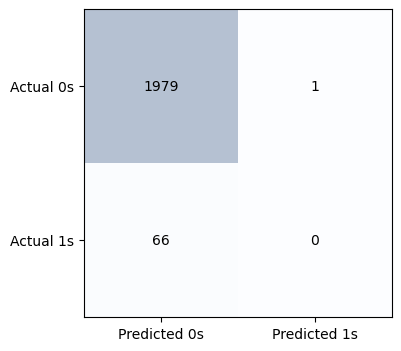

In [9]:
cm = confusion_matrix(test_y, pred_y)
plot_cm(cm)

Postoje različite strategije koje se mogu primeniti za rešavanje problema neuravnoteženosti podataka. 

Jedna strategija je biranje dobre funkcije evaluacije. Kada imamo neuravnotežene baze podataka, model koji samo predviđa dominantnu klasu može imati visoku vrednost funkcije accuracy, ali je zapravo vrlo neuspešan u identifikovanju manje zastupljenih klasa.

Druga strategija je reuzorkovanje (resampling), metodološki pristup kojim se manipuliše veličinom uzorka podataka u cilju poboljšanja performansi modela mašinskog učenja. Postoje dva osnovna tipa resamplinga: undersampling (podselekcija) i oversampling (prekomerna selekcija). 

### Undersampling

Undersampling podrazumeva smanjenje broja uzoraka zastupljenije klase tako da se izbalansiraju brojevi uzoraka između klasa. Na primer, ako imamo 1000 uzoraka za klasu 1 i samo 100 uzoraka za klasu 2, možemo uzeti samo 100 uzoraka iz klase 1 da bismo izbalansirali broj uzoraka u obe klase. 

Važno je imati na umu da undersampling može dovesti do preterane prilagođenosti (overfitting) modela i gubitka informacija iz podataka, pa se koristi samo kada je to neophodno i kada se očekuje da broj uzoraka neće uticati na performanse modela.

In [10]:
train_X_jesu_bankrotirali = train_X[train_y == 1] #pronalazimo kompanije koje su bankrotirale
train_X_nisu_bankrotirali = train_X[train_y == 0] #pronalazimo kompanije koje nisu bankrotirale

train_y_jesu_bankrotirali = train_y[train_y == 1] 
train_y_nisu_bankrotirali = train_y[train_y == 0] 

n = len(train_y[train_y == 1])
N = len(train_y[train_y == 0])

N_list = list(np.arange(1, N))
idx = sample(N_list,n) 

train_X_nisu_bankrotirali_us = train_X_nisu_bankrotirali.iloc[idx,]
train_y_nisu_bankrotirali_us = train_y_nisu_bankrotirali.iloc[idx]

# pravimo novi trening skup koji je izbalansiran
train_X_us = pd.concat([train_X_jesu_bankrotirali, train_X_nisu_bankrotirali_us])
train_y_us = pd.concat([train_y_jesu_bankrotirali, train_y_nisu_bankrotirali_us])


Demonstriraćemo KNN model za k = 15. (Za 15 smo dobili najbolje predviđanje)

In [11]:
model = KNeighborsClassifier(n_neighbors=15)
model.fit(train_X_us, train_y_us);
pred_y = model.predict(test_X)

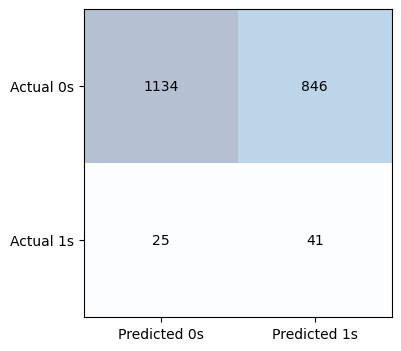

In [12]:
cm = confusion_matrix(test_y, pred_y)
plot_cm(cm)

In [13]:
mere_kvaliteta(test_y, pred_y)

F1 Score : 0.40
AUC ROC : 0.60
Precision : 0.05


Ukoliko ne želimo da se odreknemo podataka, možemo da napravimo više uravnoteženih trening skupova. U svakom od tih trening skupova nalaziće se sve kompanije koje jesu bankrotirale, a kompanije koje nisu bankrotirale biće podeljene jednako, svakom od njih.

In [14]:
#n = len(train_y[train_y == 1])
#N = len(train_y[train_y == 0])
broj_trening_skupova = N//n 
broj_trening_skupova

29

Imaćemo 29 trening skupova.

In [15]:
train_X_us2= {}
train_y_us2= {}
i = 0
while i < 29:
    train_X_tt = train_X_nisu_bankrotirali.iloc[i*n:(i+1)*n]
    train_y_tt = train_y_nisu_bankrotirali.iloc[i*n:(i+1)*n]
    
    train_X_t = pd.concat([train_X_jesu_bankrotirali, train_X_tt])
    train_y_t = pd.concat([train_y_jesu_bankrotirali, train_y_tt])
    
    train_X_us2[i] = train_X_t
    train_y_us2[i] = train_y_t
    
    i += 1


Primetimo da smo se na ovaj način odrekli podataka o nekoliko kompanija (onoliko koliko je ostatak deljenja N sa n). Ovo ne bi trebalo da značajno utiče na modele. Ukoliko zaista želimo da sačuvamo svaki podatak, možemo, na primer, da taj 'višak' podelimo jedan po jedan svakom trening skupu. Ti trening skupovi će imati jednu kompaniju više koja nije bankrotirala, što takođe ne utiče negativno na modele. Ali to sad nećemo raditi, da ne bismo dodatno zakomplikovali kod, i ne očukujemo da će rezultati biti drugačiji.

Demonstiraćemo jedan način kako možemo da upotrebimo ovaj pristup. Primenićemo kNN model za k = 15 na svaki od ovih trening skupova, a kao konačnu procenu uzećemo ocenu koja se najčešće pojavljuje medju svim modelima.

In [16]:
model = KNeighborsClassifier(n_neighbors=15)

i = 0
model.fit(train_X_us2[i], train_y_us2[i]);
pred_y_m = np.array([model.predict(test_X)])

i = 1

while i < 29:
    model.fit(train_X_us2[i], train_y_us2[i])
    pred_y_= np.array([model.predict(test_X)])
    pred_y_m = np.vstack([pred_y_m, pred_y_])
    i += 1



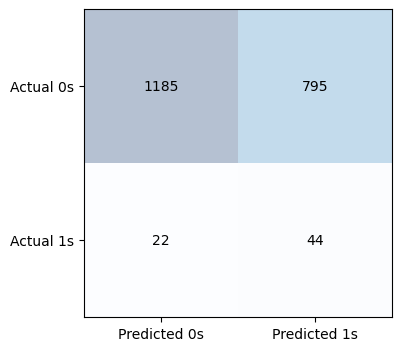

In [17]:
pred_y = najcesca_predikcija(pred_y_m[:,], broj_trening_skupova)
cm = confusion_matrix(test_y, pred_y)
plot_cm(cm)

In [18]:
mere_kvaliteta(test_y, pred_y)

F1 Score : 0.42
AUC ROC : 0.63
Precision : 0.05


Ovi rezultati nisu puno bolji od rezultata dobijenih na osnovu samo jednog trening skupa, ali su nam značajniji jer za njih znamo da nisu posledica preprilagođenosti. 

### Oversampling

Oversampling, podrazumeva dodavanje novih uzoraka u manje zastupljenu klasu, kako bi se izbalansirao broj uzoraka između klasa. Ovaj pristup se često primenjuje kada je broj uzoraka bitan faktor u performansama modela. Najjednostavniji pristup je umnožavanje postojećih uzoraka manje zastupljene klase, što se naziva up-sampling. Na primer, ako imamo 1000 uzoraka klase 1 i samo 100 uzoraka klase 2, možemo udesetostručiti uzorke klase 2 kako bismo izbalansirali broj uzoraka u obe klase.

Međutim, ovaj pristup može dovesti do preterane prilagođenosti i gubitka informacija iz podataka, jer se postojeći uzorci samo ponavljaju, bez dodavanja novih informacija. Zbog toga se često primenjuju složenije tehnike oversamplinga, kao što su Synthetic Minority Over-sampling Technique (SMOTE) i Adaptive Synthetic Sampling (ADASYN). Mi ćemo primeniti SMOTE.

In [19]:
smote = SMOTE(random_state=42)
train_X_smote, train_y_smote = smote.fit_resample(train_X, train_y)

Sada nas trening skup ima mnogo elemenata pa ćemo demonstrirati KNN model za veliko k. Odabrali smo k = 150, jer daje dobre rezultate.

In [92]:
model = KNeighborsClassifier(n_neighbors=150)
model.fit(train_X_smote, train_y_smote)
pred_y = model.predict(test_X)

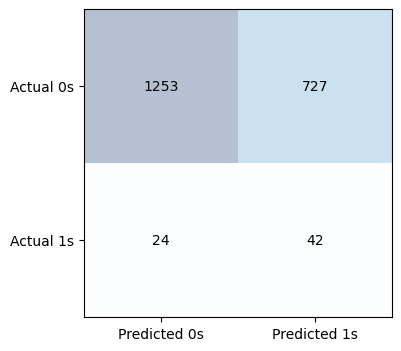

In [21]:
cm = confusion_matrix(test_y, pred_y)
plot_cm(cm)

In [22]:
mere_kvaliteta(test_y, pred_y)

F1 Score : 0.44
AUC ROC : 0.63
Precision : 0.05


## Smanjenje dimenzionalnosti podataka

Naša baza podataka sadrži veliki broj karakteristika, i mnogi od njih su međusobno korelisani što može dovesti do problema sa analizom, interpretacijom i vizualizacijom podataka. 

Postoji nekoliko pristupa za smanjenje dimenzionalnosti, kao što su:

- Odabir karakteristika (eng. feature selection) - ovo je proces odabira najrelevantnijih karakteristika za modeliranje i ignorisanje manje bitnih karakteristika.

- Smanjenje karakteristika (eng. feature extraction) - ovaj pristup koristi matematičke tehnike za transformisanje originalnih karakteristika u novi skup karakteristika, koji su kompaktniji, sa manjim brojem dimenzija, ali zadržavaju što više informacija. Primeri algoritama za smanjenje karakteristika uključuju Principal Component Analysis (PCA), t-distributed Stochastic Neighbor Embedding (t-SNE), Uniform Manifold Approximation and Projection for Dimension Reduction (UMAP).

- Kombinacija različitih algoritama za smanjenje dimenzionalnosti  (eng. ensemble methods).

### PCA

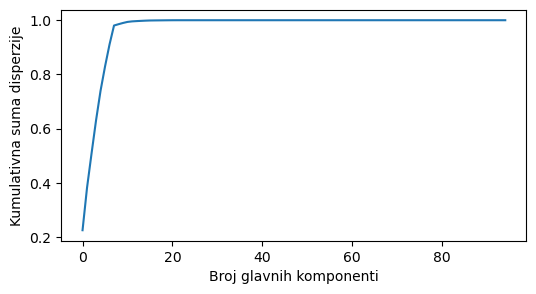

In [23]:
#X = df.iloc[:,1:96]
#y = df.iloc[:,0]

#train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=7, stratify=y)


#primenjujemo pca na nas trening skup i crtamo grafik zavisnosti kumulativne sume disperzije od broja glavnih komponenti
pca = PCA().fit(train_X)
plot_ksd(pca.explained_variance_ratio_)


In [24]:
#Sada trazimo broj glavnih komponenti dovoljan da njihov udeo u disperzi bude 99%
pca = PCA(n_components=0.99).fit(train_X)
n = pca.n_components_ 
n

11

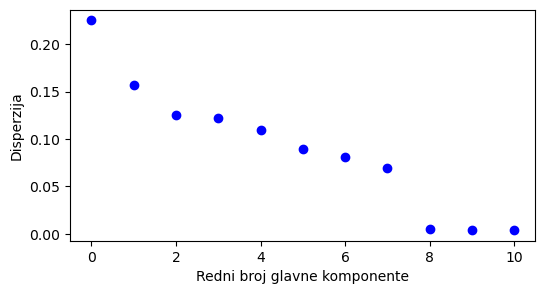

In [25]:
#Crtamo grafik udela u disperziji svake glavne komponente
plot_uud(pca.explained_variance_ratio_)

In [26]:
#sada nas trening i test skup transformisemo koristeci gore definisan 
train_X_pca = pca.fit_transform(train_X)
test_X_pca = pca.transform(test_X)
 
#primenicemo logisticku regresiju 

classifier = LogisticRegression(random_state = 4)
classifier.fit(train_X_pca, train_y)
pred_y = classifier.predict(test_X_pca)

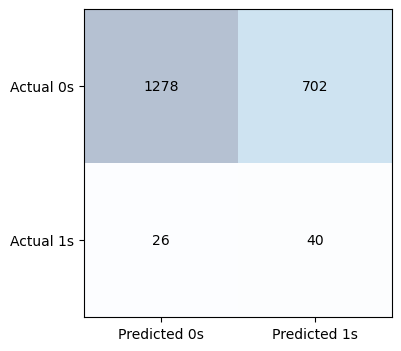

In [27]:
cm = confusion_matrix(test_y, pred_y)
plot_cm(cm)

In [28]:
mere_kvaliteta(test_y, pred_y)

F1 Score : 0.44
AUC ROC : 0.63
Precision : 0.05


#### PCA i SMOTE

Možemo i da kombinujemo PCA i SMOTE da bismo dobili uravnoteženu bazu na kojoj mozemo primeniti kNN.

In [29]:
#smote = SMOTE(random_state=42)
train_X_pca2, train_y_pca2 = smote.fit_resample(train_X_pca, train_y)

In [30]:
model = KNeighborsClassifier(n_neighbors=150)
model.fit(train_X_pca2, train_y_pca2);
pred_y = model.predict(test_X_pca)

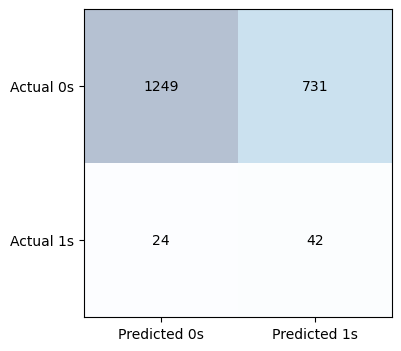

In [31]:
cm = confusion_matrix(test_y, pred_y)
plot_cm(cm)

In [32]:
mere_kvaliteta(test_y, pred_y)

F1 Score : 0.43
AUC ROC : 0.63
Precision : 0.05


### UMAP

Smanjicemo dimenziju podataka koristeci UMAP algoritam. Ovim algoritmom moramo prvo da smanjimo dimenziju cele baze, a tek onda da izdvojimo trening i test skup. Jedna mana ovog algoritma je što nove podatke ne možemo direktno da ubacimo u model, već bismo morali da primenimo sve ispočetka

Na identičan način možemo primeniti i t-SNE algoritam, ali ga nećemo demonstrirati.

Prvo ćemo svesti bazu na dve dimenzije i podatke prikazati na grafiku.

In [72]:
# X = df.iloc[:,1:96]
# y = df.iloc[:,0]

umap_ = umap.UMAP(n_components=2)
X_umap = umap_.fit_transform(X)


train_X_umap, test_X_umap, train_y_umap, test_y_umap = train_test_split(X_umap,y,test_size=0.3, random_state=42 )


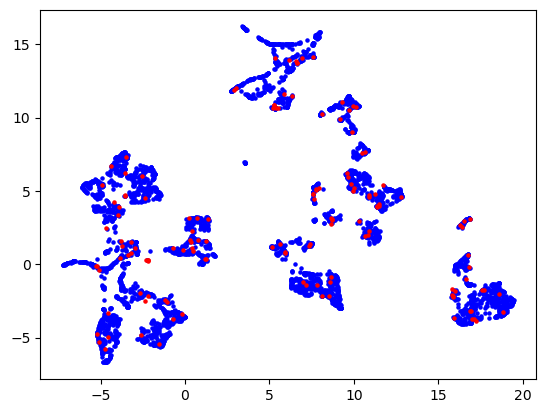

In [73]:
grafik_2d(train_X_umap, train_y_umap)

Na grafiku ne uočavamo jasnu razdvojenost, zato ćemo proširiti trening skup koristeći SMOTE.

In [74]:
smote = SMOTE(random_state=42)
train_X_umap2, train_y_umap2 = smote.fit_resample(train_X_umap, train_y_umap)

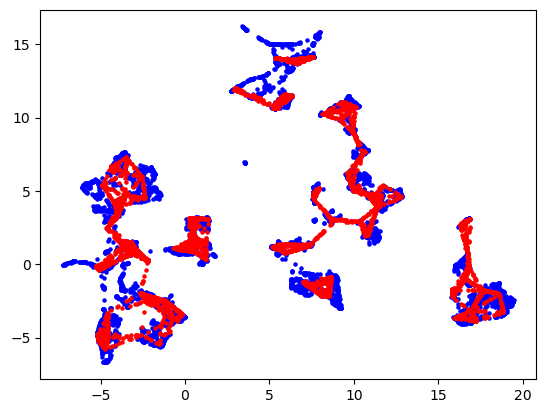

In [75]:
grafik_2d(train_X_umap2,train_y_umap2)

I dalje ne postoji jasna razdvojenost izmežu kompanija, ali možemo da primetimo da na nekim mestima postoje mali klasteri tačaka iste boje, što nam ukazuje da bismo mogli da isprobamo kNN model (kako klasteri nisu veliki, uzećemo k = 50).

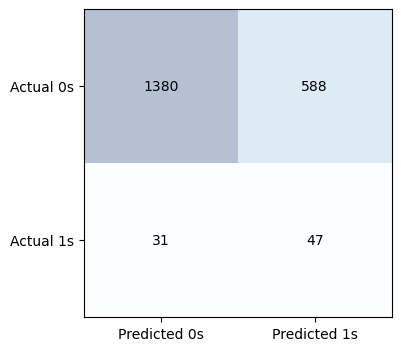

In [76]:
model = KNeighborsClassifier(n_neighbors=50)
model.fit(train_X_umap2, train_y_umap2);

pred_y = model.predict(test_X_umap)
cm = confusion_matrix(test_y_umap, pred_y)
plot_cm(cm)

In [77]:
mere_kvaliteta(test_y_umap, pred_y)

F1 Score : 0.47
AUC ROC : 0.65
Precision : 0.07


Sada ćemo opet upotrebiti UMAP, ali ovoga puta ćemo bazu svesti na 3 dimenzije i to prikazati na 3d grafiku.

In [78]:
# X = df.iloc[:,1:96]
# y = df.iloc[:,0]

umap_ = umap.UMAP(n_components=3)
X_umap3 = umap_.fit_transform(X)

train_X_umap3, test_X_umap3, train_y_umap3, test_y_umap3 = train_test_split(X_umap3,y,test_size=0.3, random_state=42 )

In [91]:
colors = train_y_umap3.astype(str)

grafik_3d(colors, train_X_umap3)

Kao i malopre, ne vidimo očiglednu razdvojenost pa ćemo zato opet primeniti SMOTE i napraviti kNN model.

In [90]:
smote = SMOTE(random_state=42)
train_X_umap4, train_y_umap4 = smote.fit_resample(train_X_umap3, train_y_umap3)

colors = train_y_umap4.astype(str)

grafik_3d(colors, train_X_umap4)

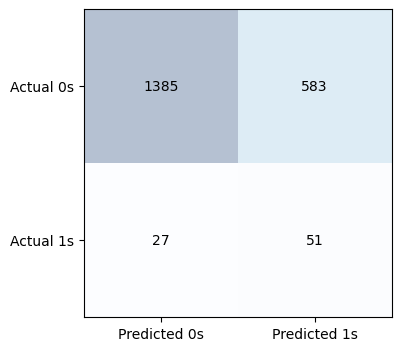

In [81]:
model = KNeighborsClassifier(n_neighbors=50)
model.fit(train_X_umap4, train_y_umap4);

pred_y = model.predict(test_X_umap3)
cm = confusion_matrix(test_y_umap3, pred_y)
plot_cm(cm)

In [82]:
mere_kvaliteta(test_y_umap3, pred_y)

F1 Score : 0.48
AUC ROC : 0.68
Precision : 0.08


### Kombinacija PCA i UMAP

In [83]:
# X = df.iloc[:,1:96]
# y = df.iloc[:,0]

pca = PCA(n_components=0.99).fit(X)
X_pca = pca.fit_transform(X)


In [84]:
umap_ = umap.UMAP(n_components=2)
X_umap5 = umap_.fit_transform(X_pca)

train_X_umap5, test_X_umap5, train_y_umap5, test_y_umap5 = train_test_split(X_umap5,y,test_size=0.3, random_state=42 )

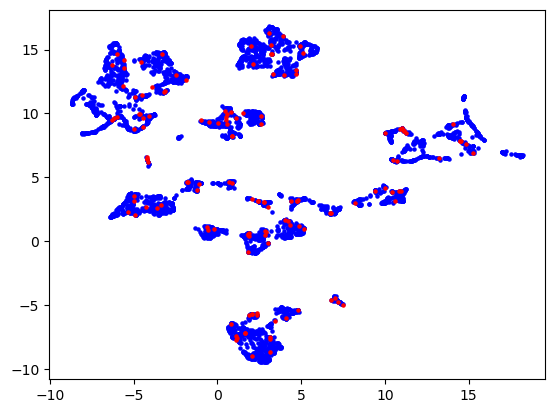

In [85]:
grafik_2d(train_X_umap5, train_y_umap5)

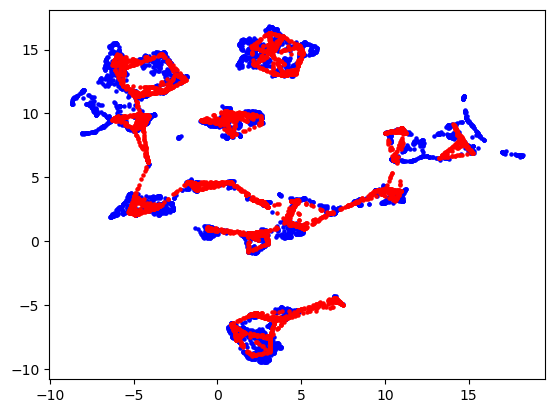

In [86]:
smote = SMOTE(random_state=42)
train_X_umap6, train_y_umap6 = smote.fit_resample(train_X_umap5, train_y_umap5)

grafik_2d(train_X_umap6, train_y_umap6)

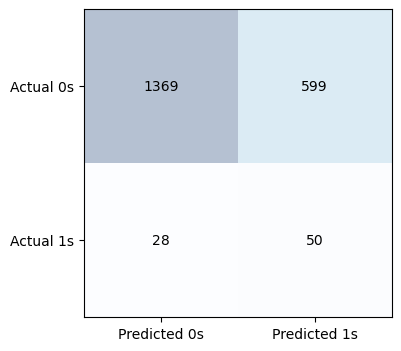

In [87]:
model = KNeighborsClassifier(n_neighbors=50)
model.fit(train_X_umap6, train_y_umap6);

pred_y = model.predict(test_X_umap5)
cm = confusion_matrix(test_y_umap5, pred_y)
plot_cm(cm)

In [88]:
mere_kvaliteta(test_y_umap5, pred_y)

F1 Score : 0.48
AUC ROC : 0.67
Precision : 0.08


## Metode klasifikacije

### Random forest

In [131]:
model_forest = ensemble.RandomForestClassifier(n_estimators=20, max_depth=3, random_state=7)
model_forest.fit(train_X, train_y)
pred_y = model_forest.predict(test_X)

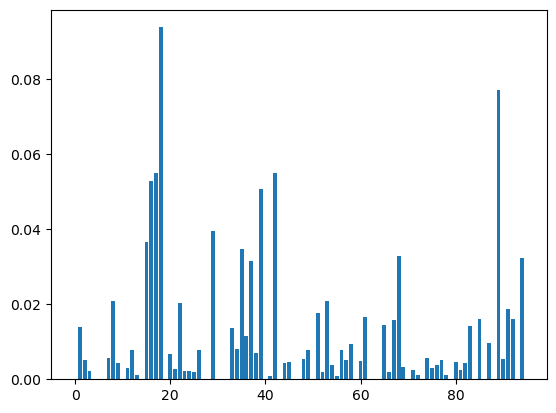

In [132]:
pyplot.bar(range(len(model_forest.feature_importances_)), model_forest.feature_importances_)
pyplot.show()

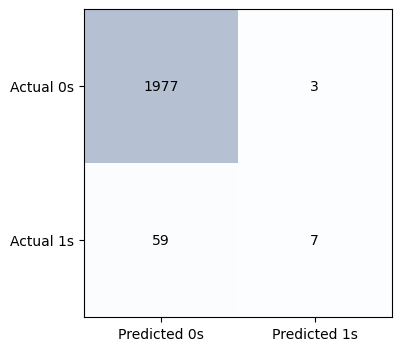

In [120]:
cm = confusion_matrix(test_y,pred_y)
plot_cm(cm)

#### Random forest + SMOTE

In [126]:
model_forest = ensemble.RandomForestClassifier(n_estimators=20, max_depth=3, random_state=7)
model_forest.fit(train_X_smote, train_y_smote)
pred_y = model_forest.predict(test_X)

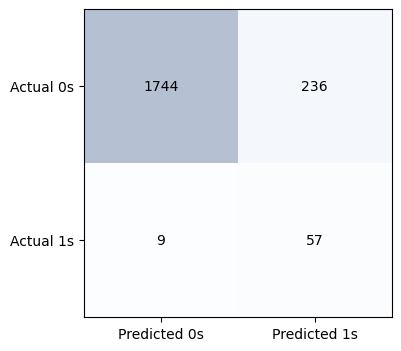

In [127]:
cm = confusion_matrix(test_y,pred_y)
plot_cm(cm)

In [118]:
mere_kvaliteta(test_y, pred_y)

F1 Score : 0.63
AUC ROC : 0.87
Precision : 0.19


### SVM

za obicnu bazu

In [33]:
svc = svm.SVC(C=100, kernel = 'rbf').fit(train_X, train_y)
pred_y = svc.predict(test_X)

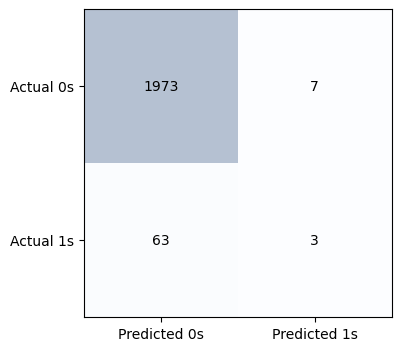

In [34]:
cm = confusion_matrix(test_y,pred_y)
plot_cm(cm)

##### Za smote

In [35]:
svc = svm.SVC(C=100, kernel = 'rbf').fit(train_X_smote, train_y_smote)
pred_y = svc.predict(test_X)

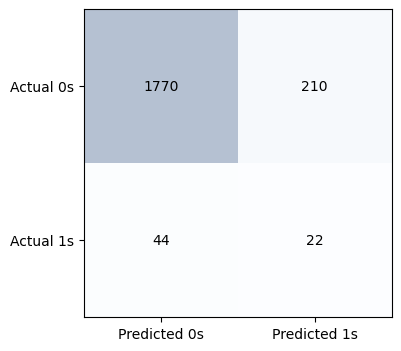

In [36]:
cm = confusion_matrix(test_y,pred_y)
plot_cm(cm)

In [37]:
mere_kvaliteta(test_y, pred_y)

F1 Score : 0.54
AUC ROC : 0.61
Precision : 0.09


##### za pca + smote

In [41]:
svc = svm.SVC(C=100, kernel = 'rbf').fit(train_X_pca2, train_y_pca2)
pred_y = svc.predict(test_X_pca)

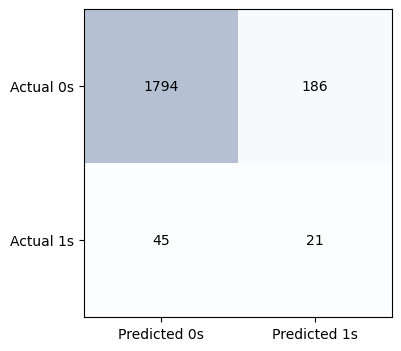

In [42]:
cm = confusion_matrix(test_y,pred_y)
plot_cm(cm)

In [43]:
mere_kvaliteta(test_y, pred_y)

F1 Score : 0.55
AUC ROC : 0.61
Precision : 0.10


##### Ovdje primenjujemo poly kernel na smote 

In [38]:
svc = svm.SVC(C=100, kernel = 'poly').fit(train_X_smote, train_y_smote)
pred_y = svc.predict(test_X)

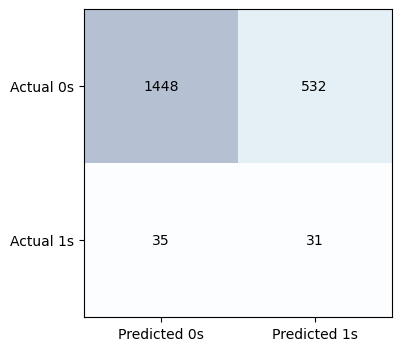

In [39]:
cm = confusion_matrix(test_y,pred_y)
plot_cm(cm)

In [40]:
mere_kvaliteta(test_y, pred_y)

F1 Score : 0.47
AUC ROC : 0.60
Precision : 0.06


#### poly na pca +smote

In [44]:
svc = svm.SVC(C=100, kernel = 'poly').fit(train_X_pca2, train_y_pca2)
pred_y = svc.predict(test_X_pca)

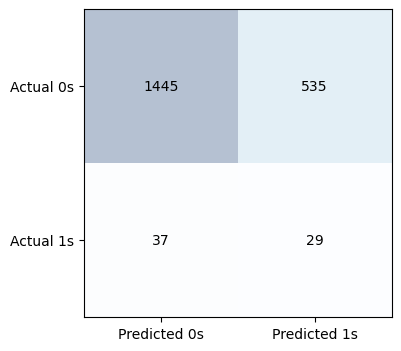

In [45]:
cm = confusion_matrix(test_y,pred_y)
plot_cm(cm)

In [46]:
mere_kvaliteta(test_y, pred_y)

F1 Score : 0.46
AUC ROC : 0.58
Precision : 0.05


### XG boost

Za 500 nema potrebe, za 100 radi dovoljno dobro, napisao sam xboost samo obicni trening skup, za smote, i za smote+pca.

##### Za obicni

In [63]:
xgb = xgboost.XGBClassifier(n_estimators=100, max_depth=5)
xgb.fit(train_X, train_y)
pred_y = xgb.predict(test_X)

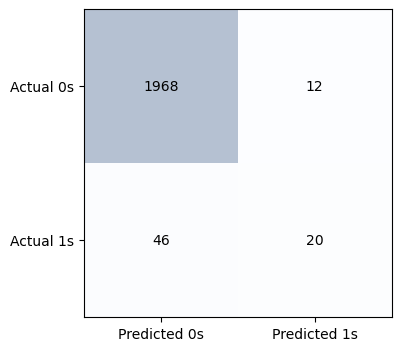

In [64]:
cm = confusion_matrix(test_y,pred_y)
plot_cm(cm)

In [65]:
mere_kvaliteta(test_y, pred_y)

F1 Score : 0.70
AUC ROC : 0.65
Precision : 0.62


In [114]:
xgb = xgboost.XGBClassifier(n_estimators=100, max_depth=5)
xgb.fit(train_X_smote, train_y_smote)
pred_y = xgb.predict(test_X)

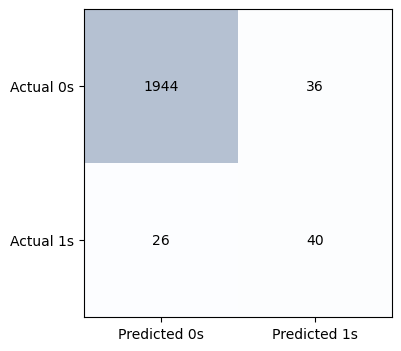

In [115]:
cm = confusion_matrix(test_y,pred_y)
plot_cm(cm)

In [116]:
mere_kvaliteta(test_y, pred_y)

F1 Score : 0.77
AUC ROC : 0.79
Precision : 0.53


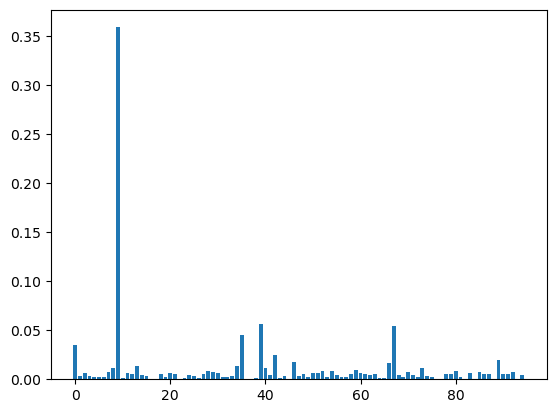

In [124]:
pyplot.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
pyplot.show()

##### za pca + smote

In [126]:
xgb = xgboost.XGBClassifier(n_estimators=100, max_depth=5)
xgb.fit(train_X_pca2, train_y_pca2)
pred_y = xgb.predict(test_X_pca)

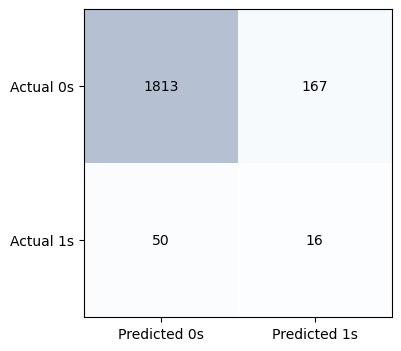

In [127]:
cm = confusion_matrix(test_y,pred_y)
plot_cm(cm)

In [128]:
mere_kvaliteta(test_y, pred_y)

F1 Score : 0.54
AUC ROC : 0.58
Precision : 0.09


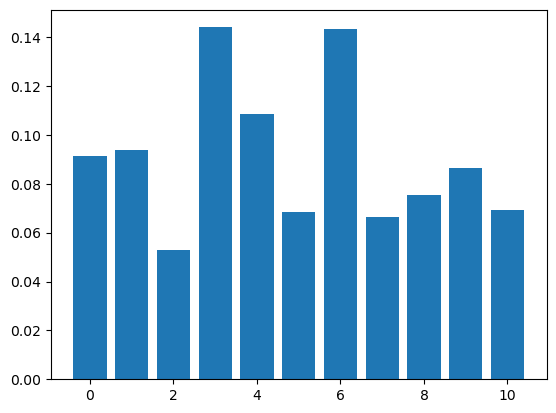

In [129]:
pyplot.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
pyplot.show()

In [134]:
df.columns

Index(['Bankrupt?', ' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' Operating Gross Margin', ' Realized Sales Gross Margin',
       ' Operating Profit Rate', ' Pre-tax net Interest Rate',
       ' After-tax net Interest Rate',
       ' Non-industry income and expenditure/revenue',
       ' Continuous interest rate (after tax)', ' Operating Expense Rate',
       ' Research and development expense rate', ' Cash flow rate',
       ' Interest-bearing debt interest rate', ' Tax rate (A)',
       ' Net Value Per Share (B)', ' Net Value Per Share (A)',
       ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons',
       ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)',
       ' Operating Profit Per Share (Yuan ¥)',
       ' Per Share Net profit before tax (Yuan ¥)',
       ' Realized Sales Gross Profit Growth Rate',
       ' Operating Profit